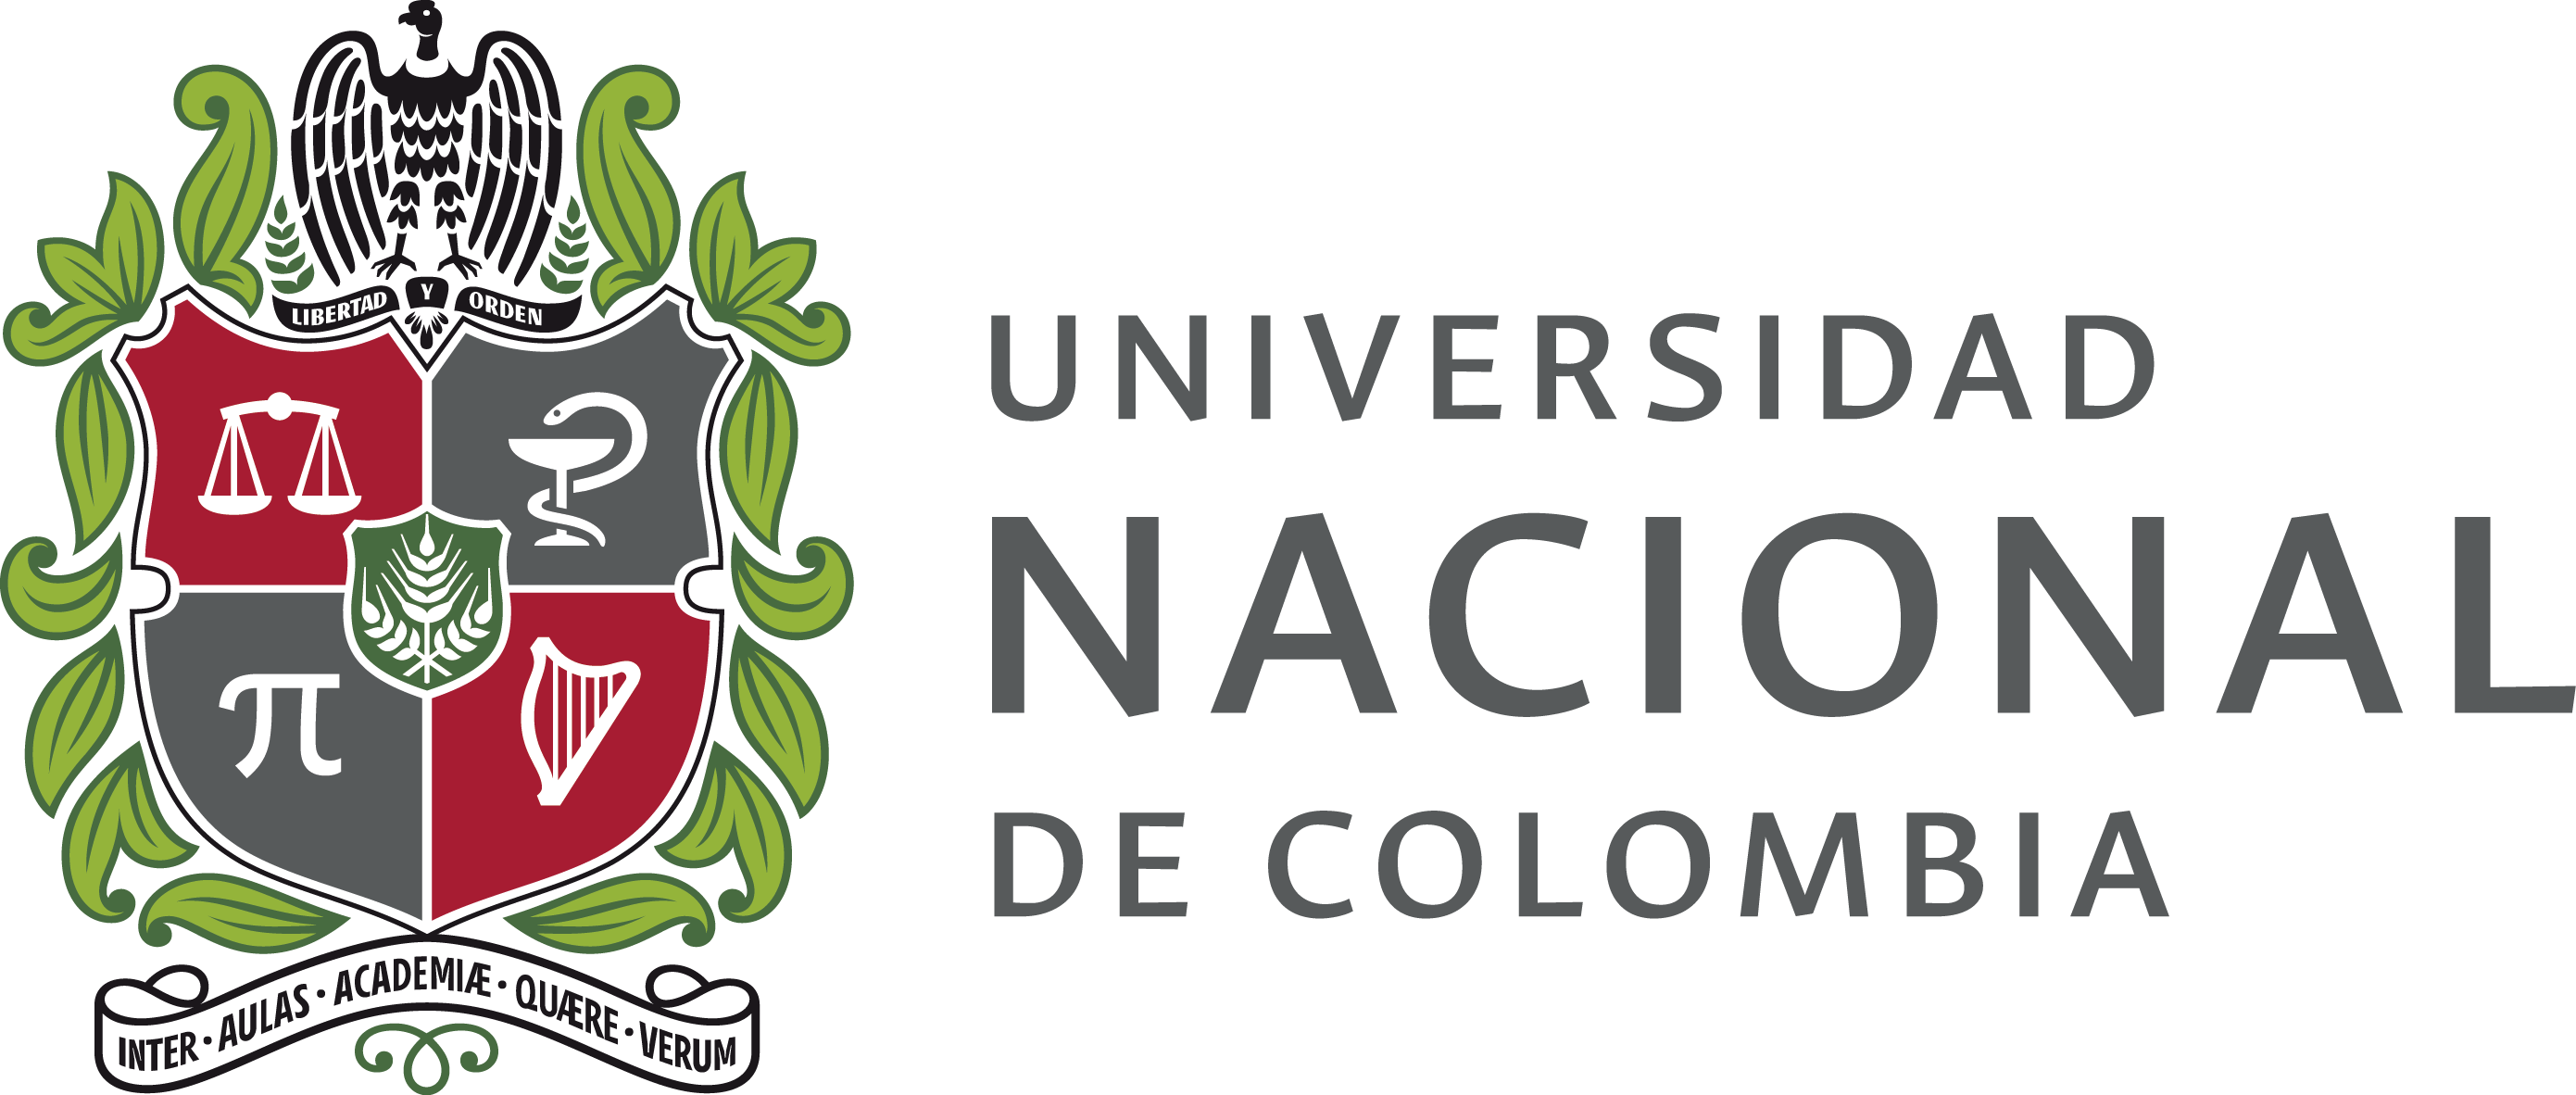

## **Despliegue del Proyecto Final en Huggging Face**
### **Universidad Nacional de Colombia sede Manizales**
#### Facultad de ingeniería y arquitecura
#### Departamento de ingeniería eléctrica, electrónica y computación
#### **Procesamiento digital de imágenes**
#### Profesor: Lucas Iturriago
#### Estudiantes: Felipe Idarraga - Julian Gutierrez

## Instalación de Roboflow

In [1]:
%%capture
!pip install roboflow

## Importación de Librerias

In [2]:
import os
import re
import glob
import time
import random
import numpy as np
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from roboflow import Roboflow
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

## **Cargar el modelo TorchScript en un nuevo Colab**
### 1. Subir el archivo plate_detector_ts.pt

In [3]:
from google.colab import files

uploaded = files.upload()  # Selecciona plate_detector_ts.pt


Saving plate_detector_ts_cpu.pt to plate_detector_ts_cpu.pt


### 2. Cargar el modelo TorchScript

Esta celda carga el archivo plate_detector_ts_cpu.pt en CPU o GPU según disponibilidad, mueve el modelo al dispositivo correspondiente, lo pone en modo evaluación y confirma que el modelo TorchScript está listo para usarse.

In [4]:
import torch

# CPU o GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Cargar el modelo TorchScript
ts_model = torch.jit.load("plate_detector_ts_cpu.pt", map_location=device)
ts_model.to(device)
ts_model.eval()

print("✅ TorchScript cargado correctamente")

Device: cuda
✅ TorchScript cargado correctamente


### 3. Probar una inferencia rápida

Esta celda crea una entrada dummy del mismo tamaño usado en el entrenamiento, la pasa por el modelo TorchScript ts_model sin gradientes y muestra la forma del tensor de salida para comprobar que la arquitectura y dimensiones son correctas.

In [5]:
import torch

# Dummy input con el mismo tamaño que usaste al entrenar (1, 3, 416, 416)
dummy_input = torch.randn(1, 3, 416, 416, device=device)

with torch.no_grad():
    out = ts_model(dummy_input)

print("Salida shape:", out.shape)  # debería ser [1, num_anchors, 13, 13, 5+num_classes]

Salida shape: torch.Size([1, 3, 15, 15, 6])


### 4. Autenticación en la sesión del notebook

Esta celda ejecuta notebook_login() para iniciar sesión en el entorno del notebook y habilitar funciones que requieren autenticación, como el acceso a recursos o servicios externos.

In [6]:
notebook_login()

### 5. Definición de parámetros del Space en Hugging Face

En esta celda se establece el usuario, el nombre del Space y construye automáticamente la URL del repositorio en Hugging Face donde se desplegará el proyecto.

In [7]:
HF_USER = "JulianGR27"
SPACE_NAME = "DetectionPlacas"
REPO_URL = f"https://huggingface.co/spaces/{HF_USER}/{SPACE_NAME}"

### 6. Clonar el repositorio del Space desde Hugging Face

Esta celda usa git clone para descargar localmente el Space indicado por la URL construida, permitiendo editar y actualizar sus archivos desde el entorno del notebook.

In [8]:
!git clone {REPO_URL}

Cloning into 'DetectionPlacas'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (13/13), 5.08 KiB | 1.69 MiB/s, done.


### 7. Configurar Git LFS y preparar el seguimiento de archivos grandes

Esta celda entra en la carpeta del Space, configura Git LFS para rastrear archivos de modelos pesados (.pt, .onnx, .tflite, etc.) y añade el archivo .gitattributes al índice de Git para que estos cambios queden registrados en el repositorio.

In [9]:
%cd {SPACE_NAME}
!git lfs track "*.keras"
!git lfs track "*.h5"
!git lfs track "*.pt"
!git lfs track "*.onnx"
!git lfs track "*.tflite"
!git lfs track "*.bin"
!git lfs track "*.safetensors"

!git add .gitattributes

/content/DetectionPlacas
"*.keras" already supported
"*.h5" already supported
"*.pt" already supported
"*.onnx" already supported
"*.tflite" already supported
"*.bin" already supported
"*.safetensors" already supported


### 8. Regresar al directorio principal del proyecto

Esta celda utiliza %cd .. para salir de la carpeta del Space y volver al directorio superior en el entorno del notebook.

In [10]:
%cd ..

/content


### 9. Copiar el modelo TorchScript al directorio del Space

Esta celda mueve el archivo plate_detector_ts_cpu.pt dentro de la carpeta del Space para que pueda ser utilizado por la aplicación desplegada en Hugging Face.

In [11]:
!cp plate_detector_ts_cpu.pt {SPACE_NAME}/

### 10. API FastAPI para detección de placas con modelo TorchScript

Esta celda crea una API con FastAPI que carga el modelo TorchScript de detección de placas, define los esquemas de entrada/salida, implementa utilidades de preprocesado y decodificación de predicciones, y expone endpoints (/, /health y /predict) para recibir imágenes en base64 y devolver las detecciones con sus cajas y puntajes.

In [12]:
%%writefile {SPACE_NAME}/app.py
from fastapi import FastAPI
from pydantic import BaseModel
import base64
import io
from typing import List

import numpy as np
from PIL import Image

import torch
import torchvision.transforms.functional as TF
from torchvision.ops import nms

# ============================================================
# CONFIG BÁSICA
# ============================================================

app = FastAPI(title="Plate Detector TorchScript API")

# Ruta del modelo TorchScript (.pt) que copiaste al repo
MODEL_PATH = "./plate_detector_ts_cpu.pt"

# Dispositivo: en Spaces normalmente CPU
device = torch.device("cpu")

# Parámetros del modelo (los mismos que en el entrenamiento)
IMAGE_SIZE = (416, 416)  # (H, W)

ANCHORS = torch.tensor([
    [47.977596, 30.171726],
    [95.66016 , 75.83388 ],
    [357.70685, 279.4956 ]
], dtype=torch.float32)

NUM_CLASSES = 1
CLASS_NAMES = ["LicensePlate"]

# Cargar modelo TorchScript
ts_model = torch.jit.load(MODEL_PATH, map_location=device)
ts_model.eval()

# ============================================================
# MODELOS Pydantic
# ============================================================

class ImagePayload(BaseModel):
    image_base64: str

class Detection(BaseModel):
    x1: float
    y1: float
    x2: float
    y2: float
    score: float
    class_id: int
    class_name: str

class PredictionResponse(BaseModel):
    detections: List[Detection]

# ============================================================
# UTILIDADES
# ============================================================

def preprocess_image(img_bytes, target_size=IMAGE_SIZE):
    """
    Preprocesa la imagen:
    - carga con PIL
    - convierte a RGB
    - redimensiona a target_size
    - devuelve tensor [1,3,H,W] en [0,1]
    """
    img = Image.open(io.BytesIO(img_bytes))

    if img.mode != "RGB":
        img = img.convert("RGB")

    img = img.resize((target_size[1], target_size[0]), Image.BILINEAR)

    img_t = TF.to_tensor(img)          # [3,H,W], float32 en [0,1]
    img_t = img_t.unsqueeze(0)         # [1,3,H,W]
    return img_t.to(device), img.size  # tamaño PIL (W,H) original

def xywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    """
    Convierte cajas (cx, cy, w, h) -> (x1, y1, x2, y2)
    boxes: [N, 4]
    """
    if boxes.numel() == 0:
        return boxes.new_zeros((0, 4))
    x1 = boxes[:, 0] - boxes[:, 2] / 2
    y1 = boxes[:, 1] - boxes[:, 3] / 2
    x2 = boxes[:, 0] + boxes[:, 2] / 2
    y2 = boxes[:, 1] + boxes[:, 3] / 2
    return torch.stack([x1, y1, x2, y2], dim=1)

def decode_predictions(pred,
                       image_size=IMAGE_SIZE,
                       anchors=ANCHORS,
                       conf_threshold=0.25,
                       nms_iou_threshold=0.5):
    """
    Decodifica la salida del modelo tipo YOLO:
    pred: [1, A, H, W, 5+C]

    Devuelve lista de detecciones en coords píxel del tamaño de entrada (416x416):
      [ {x1, y1, x2, y2, score, class_id}, ... ]
    """
    device = pred.device
    H_img, W_img = image_size

    B, A, H, W, out_ch = pred.shape
    num_classes = out_ch - 5

    # Separar predicciones
    tx = torch.sigmoid(pred[..., 0])
    ty = torch.sigmoid(pred[..., 1])
    tw = pred[..., 2]
    th = pred[..., 3]
    obj = torch.sigmoid(pred[..., 4])
    cls_logits = pred[..., 5:]  # [B,A,H,W,C]

    if num_classes > 0:
        cls_prob = torch.sigmoid(cls_logits)
        max_cls_prob, class_pred = cls_prob.max(dim=-1)  # [B,A,H,W]
    else:
        max_cls_prob = torch.ones_like(obj)
        class_pred = torch.zeros_like(obj, dtype=torch.long)

    scores = obj * max_cls_prob  # [B,A,H,W]

    # Grid
    grid_x = torch.arange(W, device=device).repeat(H, 1)
    grid_y = torch.arange(H, device=device).repeat(W, 1).t()
    gx = grid_x.view(1, 1, H, W)
    gy = grid_y.view(1, 1, H, W)

    # Anchors
    anchors = anchors.to(device).view(1, A, 1, 1, 2)

    # Decodificación a píxeles (cx,cy,w,h)
    bx = (tx + gx) * (W_img / W)
    by = (ty + gy) * (H_img / H)
    bw = anchors[..., 0] * torch.exp(tw)
    bh = anchors[..., 1] * torch.exp(th)

    # Solo manejamos B=1 para API
    bx_b = bx[0].reshape(-1)
    by_b = by[0].reshape(-1)
    bw_b = bw[0].reshape(-1)
    bh_b = bh[0].reshape(-1)
    scores_b = scores[0].reshape(-1)
    class_b = class_pred[0].reshape(-1)

    # Filtrar por confianza
    keep_conf = scores_b > conf_threshold
    if keep_conf.sum() == 0:
        return []

    bx_f = bx_b[keep_conf]
    by_f = by_b[keep_conf]
    bw_f = bw_b[keep_conf]
    bh_f = bh_b[keep_conf]
    scores_f = scores_b[keep_conf]
    class_f = class_b[keep_conf]

    boxes_cxcywh = torch.stack([bx_f, by_f, bw_f, bh_f], dim=1)
    boxes_xyxy = xywh_to_xyxy(boxes_cxcywh)  # [N,4]

    if boxes_xyxy.numel() == 0:
        return []

    # NMS
    keep = nms(boxes_xyxy, scores_f, nms_iou_threshold)

    boxes_xyxy = boxes_xyxy[keep]
    scores_f = scores_f[keep]
    class_f = class_f[keep]

    detections = []
    for i in range(boxes_xyxy.shape[0]):
        x1, y1, x2, y2 = boxes_xyxy[i].tolist()
        score = float(scores_f[i].item())
        cls_id = int(class_f[i].item())
        cls_name = CLASS_NAMES[cls_id] if 0 <= cls_id < len(CLASS_NAMES) else f"class_{cls_id}"

        detections.append({
            "x1": float(x1),
            "y1": float(y1),
            "x2": float(x2),
            "y2": float(y2),
            "score": score,
            "class_id": cls_id,
            "class_name": cls_name
        })

    return detections

# ============================================================
# ENDPOINTS
# ============================================================

@app.get("/")
def home():
    return {
        "status": "ok",
        "message": "API is running! Use POST /predict",
        "model_info": {
            "image_size": IMAGE_SIZE,
            "num_classes": NUM_CLASSES,
            "class_names": CLASS_NAMES,
            "anchors": ANCHORS.tolist()
        }
    }

@app.get("/health")
def health_check():
    return {"status": "healthy", "model_loaded": True}

@app.post("/predict", response_model=PredictionResponse)
def predict(payload: ImagePayload):
    """
    Recibe una imagen en base64, ejecuta el detector y devuelve las cajas.
    """
    try:
        # 1. Decodificar base64
        img_bytes = base64.b64decode(payload.image_base64)

        # 2. Preprocesar
        img_tensor, orig_size = preprocess_image(img_bytes, target_size=IMAGE_SIZE)

        # 3. Inferencia
        with torch.no_grad():
            preds = ts_model(img_tensor)  # [1,A,H,W,5+C]

        # 4. Decodificar a detecciones
        dets = decode_predictions(preds,
                                  image_size=IMAGE_SIZE,
                                  anchors=ANCHORS,
                                  conf_threshold=0.25,
                                  nms_iou_threshold=0.5)

        # 5. Convertir a objetos Detection
        detections = [
            Detection(**d) for d in dets
        ]

        return PredictionResponse(detections=detections)

    except Exception as e:
        # En producción podrías loggear el error
        return PredictionResponse(detections=[])


Overwriting DetectionPlacas/app.py


### 11. Definición de dependencias para el Space en Hugging Face

Esta celda genera el archivo requirements.txt dentro del Space, listando las librerías necesarias (FastAPI, Uvicorn, Pydantic, NumPy, Pillow, Torch y Torchvision) para que el entorno instale automáticamente todas las dependencias de la API.

In [13]:
%%writefile {SPACE_NAME}/requirements.txt
fastapi
uvicorn[standard]
pydantic
numpy
pillow
torch
torchvision

Overwriting DetectionPlacas/requirements.txt


### 12. Especificación de la versión de Python para el Space

Esta celda crea el archivo runtime.txt, indicando que el Space debe ejecutarse usando Python 3.10, garantizando compatibilidad con las dependencias y el modelo.

In [14]:
%%writefile {SPACE_NAME}/runtime.txt
python-3.10

Overwriting DetectionPlacas/runtime.txt


### 13. Creación del README del Space en Hugging Face

Esta celda genera el archivo README.md del Space, definiendo metadatos (título, emoji, colores, SDK) y una breve descripción de la API de detección de placas vehiculares basada en PyTorch/TorchScript y FastAPI.

In [15]:
%%writefile {SPACE_NAME}/README.md
---
title: PlateDetectionSpace
emoji: 🚘
colorFrom: blue
colorTo: purple
sdk: docker
pinned: false
---

# PlateDetectorAPI

API en Hugging Face Space para detección de placas vehiculares usando PyTorch/TorchScript y FastAPI.


Overwriting DetectionPlacas/README.md


### 14. Definición del Dockerfile para desplegar la API de detección de placas

Esta celda crea el Dockerfile del Space usando Python 3.10, instala las dependencias desde requirements.txt, copia el código de la app, expone el puerto 7860 y lanza el servidor Uvicorn con la aplicación FastAPI app:app.

In [16]:
%%writefile {SPACE_NAME}/Dockerfile
FROM python:3.10

# Crear usuario no-root
RUN useradd -m -u 1000 user
USER user
ENV PATH="/home/user/.local/bin:$PATH"

WORKDIR /app

COPY --chown=user ./requirements.txt /app/requirements.txt
RUN pip install --no-cache-dir -r requirements.txt

COPY --chown=user . /app

EXPOSE 7860

CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "7860"]

Overwriting DetectionPlacas/Dockerfile


### 15. Configuración del usuario de Git para commits

Esta celda establece el correo y nombre de usuario globales de Git, permitiendo realizar commits y pushes al repositorio del Space con la identidad configurada.

In [17]:
!git config --global user.email "jgutierrezra@unal.edu.co"
!git config --global user.name "JulianGR27"

### 16. Commit y push de la API al Space en Hugging Face

Esta celda entra en la carpeta del Space, agrega todos los cambios al índice, crea un commit con un mensaje descriptivo y envía el contenido actualizado al repositorio remoto en Hugging Face.

In [18]:
%cd {SPACE_NAME}
!git add .
!git commit -m "PlateDetectionSpace: API de detección de placas con PyTorch/TorchScript y FastAPI."
!git push

/content/DetectionPlacas
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://huggingface.co': No such device or address


In [19]:
%cd ..

/content


### 17. Subir imagenes para probar modelo

In [ ]:
from google.colab import files

# Abrir diálogo para seleccionar archivos desde tu PC
uploaded = files.upload()

# 'uploaded' es un diccionario: {nombre_archivo: contenido_bytes}
print("Archivos subidos:")
for filename in uploaded.keys():
    print(f"- {filename}")


### 18. Prueba de la API enviando una imagen en base64

Esta celda carga una imagen local, la convierte a base64, envía una solicitud POST al endpoint /predict del Space en Hugging Face y muestra el código de estado y parte de la respuesta devuelta por la API.

In [21]:
import requests
import base64

# 1. Leer imagen de prueba
with open("./Carros3.png", "rb") as f:   # cambiar open("./RUTA_IMAGEN", "rb") que desee probar
    img_bytes = f.read()

# 2. Convertir a base64
img_b64 = base64.b64encode(img_bytes).decode("utf-8")
payload = {"image_base64": img_b64}

# 3. Enviar request
url = "https://JulianGR27-DetectionPlacas.hf.space/predict"

res = requests.post(url, json=payload)

print("Status code:", res.status_code)
print("Raw response (primeros 500 chars):")
print(res.text[:500])


Status code: 200
Raw response (primeros 500 chars):
{"detections":[{"x1":58.81324005126953,"y1":257.5664367675781,"x2":126.36479949951172,"y2":313.9884948730469,"score":0.987565279006958,"class_id":0,"class_name":"LicensePlate"}]}


### 19. Lectura y visualización de las detecciones devueltas por la API

Esta celda convierte la respuesta JSON en un diccionario y recorre cada detección, mostrando las coordenadas de la caja, el puntaje de confianza y la clase identificada por el modelo.

In [22]:
data = res.json()
for det in data["detections"]:
    print("Caja:", det["x1"], det["y1"], det["x2"], det["y2"])
    print("Score:", det["score"])
    print("Clase:", det["class_id"], det["class_name"])


Caja: 58.81324005126953 257.5664367675781 126.36479949951172 313.9884948730469
Score: 0.987565279006958
Clase: 0 LicensePlate


### 20. Visualización de las detecciones sobre la imagen original

Esta celda carga la imagen de prueba, la redimensiona a 416×416, dibuja sobre ella los bounding boxes y etiquetas devueltos por la API (clase y score) y luego muestra el resultado con matplotlib.


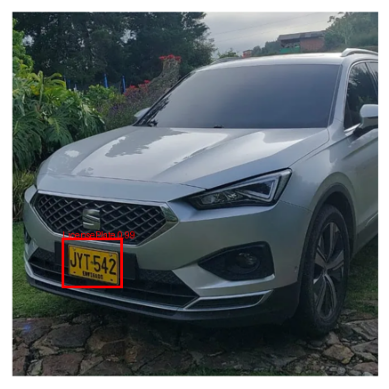

In [24]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# 1. Cargar y redimensionar la misma imagen
img = Image.open("./Carros3.png").convert("RGB")  # cambiar Image.open("./RUTA_IMAGEN") que desee probar
img = img.resize((416, 416))  # mismo tamaño que usa el modelo

# 2. Dibujar la(s) caja(s)
draw = ImageDraw.Draw(img)

for det in data["detections"]:
    x1, y1 = det["x1"], det["y1"]
    x2, y2 = det["x2"], det["y2"]
    score = det["score"]
    label = f'{det["class_name"]} {score:.2f}'

    # rectángulo
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
    # texto encima
    draw.text((x1, y1 - 10), label, fill="red")

# 3. Mostrar
plt.imshow(img)
plt.axis("off")
plt.show()
